In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

In [ ]:
buoy=pd.read_csv('data/buoy41002.csv')
buoy['time']=pd.to_datetime(buoy['time'])
Y_train=buoy.loc[buoy['fold']<=3]
Y_val=buoy.loc[buoy['fold']==4]
Y_test=buoy.loc[buoy['fold']==5]
Y_train

train_times=Y_train['time']
val_times=Y_val['time']
test_times=Y_test['time']

In [ ]:
# Window size is 2n+1
n=10

center=[360-75,31.75]
lats=np.arange(center[1]-n*.25,center[1]+(n+1)*.25,.25)
lons=np.arange(center[0]-n*.25,center[0]+(n+1)*.25,.25)
# Get locations within image
lat_bounds=[min(lats),max(lats)]
lon_bounds=[min(lons),max(lons)]

# Read in NBS
nbs=xr.open_dataset('data/nbs_train.nc')
nbs=nbs.sel(lat=slice(min(lats),max(lats)),lon=slice(min(lons),max(lons)))

X_train=nbs.sel(time=nbs['time'].isin(Y_train['time']))
X_val=nbs.sel(time=nbs['time'].isin(Y_val['time']))
X_test=nbs.sel(time=nbs['time'].isin(Y_test['time']))

In [ ]:
Y_train=np.array(Y_train['w'])
Y_val=np.array(Y_val['w'])
Y_test=np.array(Y_test['w'])

X_train=np.array(X_train['w'])
X_val=np.array(X_val['w'])
X_test=np.array(X_test['w'])

In [ ]:
# Scale the data
scale_y=1/Y_train.max()
Y_train=Y_train*scale_y
Y_val=Y_val*scale_y
Y_test=Y_test*scale_y
Y_test.min(),Y_test.max()

scale_x=1/X_train.max()
X_train=X_train*scale_x
X_val=X_val*scale_x
X_test=X_test*scale_x
X_test.min(),X_test.max()

(0.0047540325, 0.983438)

In [ ]:
Y_train.min(),Y_train.max()

(0.008237515016303416, 1.0)

In [ ]:
X_train=X_train.squeeze()
X_val=X_val.squeeze()
X_test=X_test.squeeze()

In [ ]:
Y_test.shape

(1635,)

In [ ]:
# model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(21, 21, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='linear'))

In [ ]:
model.compile(loss = "MeanSquaredError", metrics='mse',
              optimizer=keras.optimizers.Adam(learning_rate = 1e-5))

In [ ]:
epochs=10
batch_size=256

In [ ]:
history=model.fit(X_train,Y_train,epochs=epochs,
                  batch_size=batch_size, validation_data=(X_val,Y_val))

Epoch 1/10
 1/75 [..............................] - ETA: 5s - loss: 0.1130 - mse: 0.1130

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


75/75 [==============================] - 3s 43ms/step - loss: 0.1025 - mse: 0.1025 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 2/10
75/75 [==============================] - 4s 48ms/step - loss: 0.0801 - mse: 0.0801 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 3/10
75/75 [==============================] - 3s 41ms/step - loss: 0.0598 - mse: 0.0598 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 4/10
75/75 [==============================] - 3s 42ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 5/10
75/75 [==============================] - 4s 48ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 6/10
75/75 [==============================] - 3s 41ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 7/10
75/75 [==============================] - 3s 41ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 8/10
75/75 [==============================] - 3s 42ms/step - loss: 0.0095 - mse: 0.0095 

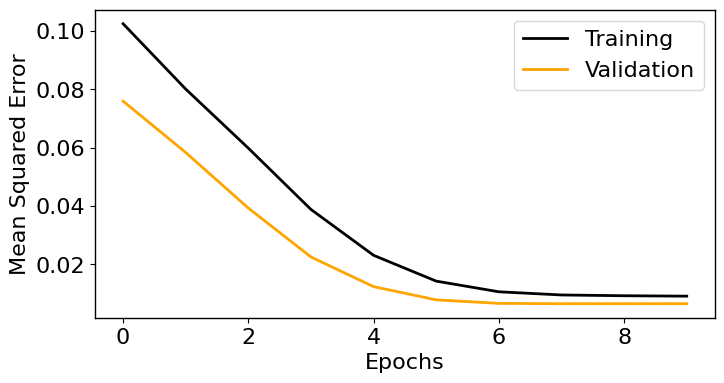

In [ ]:
# Plot training graph

fig = plt.figure(figsize=(8, 4))
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1
plt.plot(history.history['mse'], label='Training', color='black', linewidth=2)
plt.plot(history.history['val_mse'], label = 'Validation', color='orange', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('CNN_normalized01_loss.png')

In [ ]:
pred = model.predict(X_test)

52/52 [==============================] - 0s 5ms/step


In [ ]:
from joblib import dump

In [ ]:
dump(model,'CNN_normalized01.joblib')

['CNN_normalized01.joblib']

In [ ]:
pred=pred/scale_y
true=Y_test/scale_y

(np.mean((pred-true)**2))**0.5

3.588444569421501

In [ ]:
pred=pred.squeeze()

In [ ]:
diffs=pred-true
pd.DataFrame(diffs).describe()

,0
count,1635.000000
mean,0.166462
std,1.931030
min,-7.713333
25%,-0.985184
50%,0.185084
75%,1.332679
max,8.033140


In [ ]:
diffs=abs(pred-true)
pd.DataFrame(diffs).describe()

,0
count,1635.000000
mean,1.487188
std,1.242385
min,0.000381
25%,0.562253
50%,1.169990
75%,2.087268
max,8.033140


In [ ]:
(np.mean((pred-true)**2))**0.5

1.937602704628312

In [ ]:
results=pd.DataFrame({'time':test_times,'pred':pred,'true':true})
results

,time,pred,true
23757,2017-01-16 00:00:00,4.938920,4.300000
23758,2017-01-16 06:00:00,4.864839,3.745714
23759,2017-01-16 12:00:00,5.106704,1.562162
23760,2017-01-16 18:00:00,5.294992,3.080000
23761,2017-01-17 00:00:00,4.957307,3.994595
...,...,...,...
25387,2018-02-28 06:00:00,7.552524,7.011429
25388,2018-02-28 12:00:00,7.002525,6.145946
25389,2018-02-28 18:00:00,7.102753,5.382857
25390,2018-03-01 00:00:00,7.105486,5.162162


Text(0.5, 1.0, 'CNN Output for Test Data')

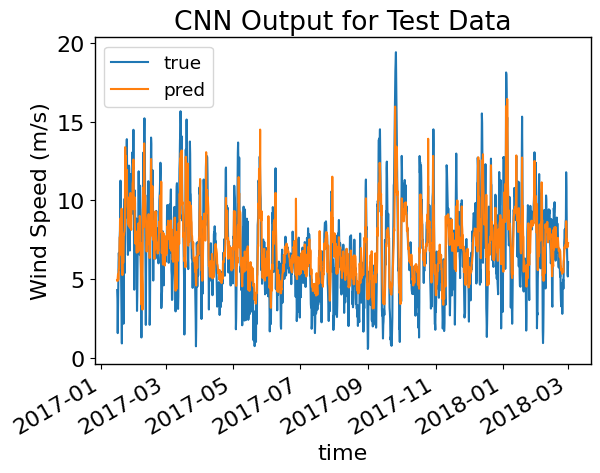

In [ ]:
results.plot(x='time',y=['true','pred'])
plt.legend(fontsize='small')
plt.ylabel('Wind Speed (m/s)')
plt.title('CNN Output for Test Data')

In [ ]:
results.to_csv('CNN_normalized01_testresults.csv')